<a href="https://colab.research.google.com/github/myrronaguila/analyze_sqc/blob/main/Plots/cpw_Qi_Loss_tls_rad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resonator Decay Mechanisms
by Myrron Albert Callera Aguila, PhD (first updated 20230829)

The works covers metrological assessment of Two-Level System (TLS) dissipation, relevent QP-induced effects and radiation losses in $\lambda/4$ resonators.

###Disclaimer:

For users of this notebook who find the contents here useful for their ongoing work, please cite or acknowledge my contribution to your work, no matter how small it is. This means a lot. Ideas put in this package took months or even years of expertise to implement.

In [ ]:
!pip install lmfit==1.2.2
!pip install uncertainties==0.18.3

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import lmfit as lm
import pandas as pd

In [ ]:
from lmfit import Model, Parameters
from lmfit.models import LorentzianModel, SineModel, ExponentialModel
from uncertainties import ufloat

In [ ]:
# set idea
#fundamental constants. obtained from wiki rather than fundamental constants
#from scipy.constants import epsilon_0, mu_0, hbar, k
e0 = 8.8541878128E-12 #F m^s
mu0 = 1.25663706212E-16 #N A^-2
kb = 1.380649E-23 #J K^-1
hbar = 1.054571817E-34 #J s
c = 299792458 # speed of light m s^-2

## 1) Subroutines for TLS Model calculations - photon-number dependence due to E-field or weakly interacting TLS

The internal quality factor $Q_{i}$ of readout resonators affected not only by fabrication and design quantified by the Two-Level Systems (TLS) (or Two-Level States by Prof. John Martinis) $Q_{tls}$ but also of the external packaging environment. Hence, clarity on various contributions due to fabrication and qubit shielding is a must. Here, we address macroscopic variables such as $Q_{i,tls}$ which would be of help in quantifying fabrication processes.

A model representing the internal quality-factor $Q_{i}$ dependence on photon number $n$ for uniform distribution of TLSs on the center trace of the readout resonator with frequency $f_{r}$  is written as [1] $$\frac{1}{Q_{i}} = \frac{1}{Q_{imtls}}\frac{\rm{tanh}(\frac{hf_{r}}{2k_B T})}{\sqrt{1+(n/n_{c})^{\phi}}}+\frac{1}{Q_{i,non-tls}}$$
where $Q_{tls}$ is the contribution associated with TLS dissipation, $Q_{i,ntls}$ are non-TLS contributions, $n_{c}$ is the critical photon number, $h$ and $k_{B}$ are fundamental constants, $T$ is the bath temperature, and $\phi$ is a rate-dependence factor attributed to an interacting TLS model, or geometric-dependent fields [2]. Note that in the absence of the qubit, the critical photon number $n_{c}$ pertains to the number of photons where the onset of saturation due to TLS occurs (i.e. the $1/Q_{i}$ starts to have non-linear dependence with $n$.  

Note that resonators and transmon qubits follow the same TLS and laws, and minimizing $Q_{TLS}$ is one key for improving qubit $T_{1}$.

In [ ]:
# Q_tls from CPW resonators, dealing from Robert's analysis
# Reference from Q_tls by photon number - from the model given by IMEC
def Q_inv_n(n, Q_inv_t, Q_inv_nt, phi, args):
  """
  Photon-number TLS terms to extract Q_tls
  # model obtained from Argon-Milling
  PHYSICAL REVIEW APPLIED 20, 014034 (2023)
  # Argon-Milling-Induced Decoherence Mechanisms in Superconducting Quantum Circuits

  input:
  n : 1D numpy array
    mean photon number
  phi : float
    interaction parameter (phi<1) => interactive TLS model or geometry-dependent
    Electrical field
  Q_inv_t : float
    inverse contribution of TLS
  Q_inv_nt : float
    inverse non-contribution of TLS
  args : list of floats
    args[0] = fr
    args[1] = T
    args[2] = nc => critical photon number
    note: for resonator qubit, nc = (delta/(2g))^2 where g is the qubit-resonator coupling strength and delta is wq-wr
    note: for bare qubit, nc is critical photon number on the onset of TLS
  output:
    best fit : 1D numpy array
      expected behavior
  """
  # set information
  fr = args[0] # can be plugged as an array to account for correction
  T = args[1] # can be plugges as constant
  nc = args[2] # can be plugged

  #guess function is Q_inv_t, and Q_inv_nt, phi and nc based on the slope of the plot

  wr = 2*np.pi*fr

  # set key information of Q_inv
  A = hbar*wr/(2*kb*T)
  n_arr = np.sqrt(1+(n/nc)**phi)
  B = (Q_inv_t)*(np.tanh(A)/n_arr)
  C = Q_inv_nt
  y_arr = B+C
  return y_arr

### Simulate TLS Estimation based on [1]

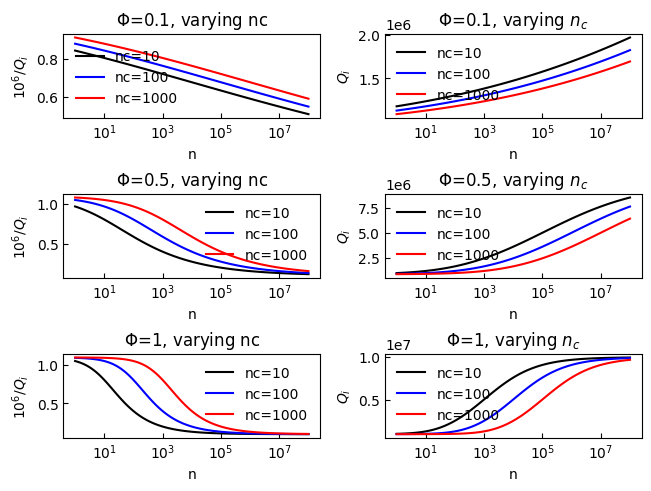

In [ ]:
#parameter of res 2 of LER
#assume inset of aluminum
fr2 = 4.8E9 #GHz
scale_f2 = 1E6
n = np.logspace(0, 8, 101)
phi_n = 0.44 # phase
phi_err = 0.08 #phase error
T_b = 10E-3 #10 mK
Q_inv_t2 = 1E-6 #250 kHz
Q_inv_nt2 = 0.1*Q_inv_t2

#we vary n_c
n_c_1 = 1E1 #critical no
n_c_2 = 1E2 #
n_c_3 = 1E3

#phi = 0.1
phi_n0=0.1
wQ_inv_n_res2_1 =  Q_inv_n(n=n, Q_inv_t=Q_inv_t2, Q_inv_nt=Q_inv_nt2, phi=phi_n0,
                          args = [fr2, T_b, n_c_1])
wQ_inv_n_res2_2 =  Q_inv_n(n=n, Q_inv_t=Q_inv_t2, Q_inv_nt=Q_inv_nt2, phi=phi_n0,
                          args = [fr2, T_b, n_c_2])
wQ_inv_n_res2_3 =  Q_inv_n(n=n, Q_inv_t=Q_inv_t2, Q_inv_nt=Q_inv_nt2, phi=phi_n0,
                          args = [fr2, T_b, n_c_3])

#put guess of Qr and Qi for trial of Aluminum for dependence of nc, phi=0.44
phi_n1 =0.5
sQ_inv_n_res2_1 =  Q_inv_n(n=n, Q_inv_t=Q_inv_t2, Q_inv_nt=Q_inv_nt2, phi=phi_n1,
                          args = [fr2, T_b, n_c_1])
sQ_inv_n_res2_2 =  Q_inv_n(n=n, Q_inv_t=Q_inv_t2, Q_inv_nt=Q_inv_nt2, phi=phi_n1,
                          args = [fr2, T_b, n_c_2])
sQ_inv_n_res2_3 =  Q_inv_n(n=n, Q_inv_t=Q_inv_t2, Q_inv_nt=Q_inv_nt2, phi=phi_n1,
                          args = [fr2, T_b, n_c_3])

#phi = 1 #beyond phi=1, the interaction should be strongly coupled.
phi_n2=1
pQ_inv_n_res2_1 =  Q_inv_n(n=n, Q_inv_t=Q_inv_t2, Q_inv_nt=Q_inv_nt2, phi=phi_n2,
                          args = [fr2, T_b, n_c_1])
pQ_inv_n_res2_2 =  Q_inv_n(n=n, Q_inv_t=Q_inv_t2, Q_inv_nt=Q_inv_nt2, phi=phi_n2,
                          args = [fr2, T_b, n_c_2])
pQ_inv_n_res2_3 =  Q_inv_n(n=n, Q_inv_t=Q_inv_t2, Q_inv_nt=Q_inv_nt2, phi=phi_n2,
                          args = [fr2, T_b, n_c_3])

# plot
#plot data
fig = plt.figure(constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=3, figure=fig, hspace =0.05,
                                 wspace=0.05)

ax0 = fig.add_subplot(spec[0, 0]) #Q_inv, vary nc, phi=0.1
ax1 = fig.add_subplot(spec[1, 0]) #Q_inv, vary nc, phi=0.5
ax2 = fig.add_subplot(spec[2, 0]) #Q_inv, vary nc, phi=1
ax3 = fig.add_subplot(spec[0, 1]) #Q, vary nc, phi=0.1
ax4 = fig.add_subplot(spec[1, 1]) #Q, vary nc, phi=0.5
ax5 = fig.add_subplot(spec[2, 1]) #Q, vary nc, phi=1

#scale*Qinv
ax0.set_title(r'$\Phi$=0.1, varying nc')
ax0.plot(n, scale_f2*wQ_inv_n_res2_1, 'k-', label='nc='+ str(int(n_c_1)))
ax0.plot(n, scale_f2*wQ_inv_n_res2_2, 'b-', label='nc='+ str(int(n_c_2)))
ax0.plot(n, scale_f2*wQ_inv_n_res2_3, 'r-', label='nc='+ str(int(n_c_3)))
ax0.set_xscale('log')
ax0.set_xlabel('n')
ax0.set_ylabel(r'$10^{6}/Q_{i}$')
ax0.tick_params(axis='both', direction='in')
ax0.legend(loc='best', frameon=False)

ax1.set_title(r'$\Phi$=0.5, varying nc')
ax1.plot(n, scale_f2*sQ_inv_n_res2_1, 'k-', label='nc='+ str(int(n_c_1)))
ax1.plot(n, scale_f2*sQ_inv_n_res2_2, 'b-', label='nc='+ str(int(n_c_2)))
ax1.plot(n, scale_f2*sQ_inv_n_res2_3, 'r-', label='nc='+ str(int(n_c_3)))
ax1.set_xscale('log')
ax1.set_xlabel('n')
ax1.set_ylabel(r'$10^{6}/Q_{i}$')
ax1.tick_params(axis='both', direction='in')
ax1.legend(loc='best', frameon=False)

ax2.set_title(r'$\Phi$=1, varying nc')
ax2.plot(n, scale_f2*pQ_inv_n_res2_1, 'k-', label='nc='+ str(int(n_c_1)))
ax2.plot(n, scale_f2*pQ_inv_n_res2_2, 'b-', label='nc='+ str(int(n_c_2)))
ax2.plot(n, scale_f2*pQ_inv_n_res2_3, 'r-', label='nc='+ str(int(n_c_3)))
ax2.set_xscale('log')
ax2.set_xlabel('n')
ax2.set_ylabel(r'$10^{6}/Q_{i}$')
ax2.tick_params(axis='both', direction='in')
ax2.legend(loc='best', frameon=False)

#Q
ax3.set_title(r'$\Phi$=0.1, varying $n_c$')
ax3.plot(n, 1/wQ_inv_n_res2_1, 'k-', label='nc='+ str(int(n_c_1)))
ax3.plot(n, 1/wQ_inv_n_res2_2, 'b-', label='nc='+ str(int(n_c_2)))
ax3.plot(n, 1/wQ_inv_n_res2_3, 'r-', label='nc='+ str(int(n_c_3)))
ax3.set_xscale('log')
ax3.set_xlabel('n')
ax3.set_ylabel(r'$Q_{i}$')
ax3.tick_params(axis='both', direction='in')
ax3.legend(loc='best', frameon=False)

ax4.set_title(r'$\Phi$=0.5, varying $n_c$')
ax4.plot(n, 1/sQ_inv_n_res2_1, 'k-', label='nc='+ str(int(n_c_1)))
ax4.plot(n, 1/sQ_inv_n_res2_2, 'b-', label='nc='+ str(int(n_c_2)))
ax4.plot(n, 1/sQ_inv_n_res2_3, 'r-', label='nc='+ str(int(n_c_3)))
ax4.set_xscale('log')
ax4.set_xlabel('n')
ax4.set_ylabel(r'$Q_{i}$')
ax4.tick_params(axis='both', direction='in')
ax4.legend(loc='best', frameon=False)

ax5.set_title(r'$\Phi$=1, varying $n_c$')
ax5.plot(n, 1/pQ_inv_n_res2_1, 'k-', label='nc='+ str(int(n_c_1)))
ax5.plot(n, 1/pQ_inv_n_res2_2, 'b-', label='nc='+ str(int(n_c_2)))
ax5.plot(n, 1/pQ_inv_n_res2_3, 'r-', label='nc='+ str(int(n_c_3)))
ax5.set_xscale('log')
ax5.set_xlabel('n')
ax5.set_ylabel(r'$Q_{i}$')
ax5.tick_params(axis='both', direction='in')
ax5.legend(loc='best', frameon=False)

plt.show()

#the plot works

Note that $\phi=0.1$ means there is weak dependence between TLS and the resonator / qubit. Strongly-coupled TLS occurs when $\phi\ge1$, which often happens when the loss of the resonator surface place a huge role in the dissipation.

### Fitting routine to $Q_{TLS}$ and $Q_{r}$ from sample fit from Resonator 3 (100 uW) of Van Damme et al (Fig 1(b) of [1]).

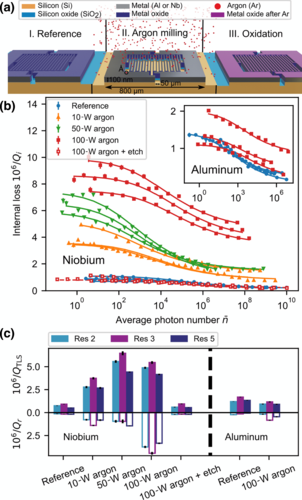

In [ ]:
def cm_to_inch(x):
  return x/2.54

def read_csv(fname):
  """
  Analyze Data from CSV files (check if you have header)
  """
  df = pd.DataFrame(pd.read_csv(fname + '.csv', header=None))
  #column 0 - x-axis
  #column 1 - y-axis
  return df

def Q_inv_n(n, Q_inv_t, Q_inv_nt, phi, nc, fr, T):
  """
  Extracting Q_inv_tls and Q_inv_non-tls from Power-dependent results
  Input:
    n : 1D numpy array
        Photon number
    Q_inv_t : float
        Inverse of Q_i_tls
    Q_inv_nt : float
        Inverse of Q_i_non tls
    phi : float
        ranges from 0-2. Interaction factor
    nc : float
        critical photon number where resonators get saturation
    fr : float
        resonator frequency in Hz
    T : float
        bath temperature in Hz
  """

  #guess info: Q_inv_t and Q_inv_nt, phi.
  #nc perhaps determined from resonant frequency, onset of frequency shift.

  wr = 2*np.pi*fr

  # set key information of Q_inv
  A = hbar*wr/(2*kb*T)
  n_arr = np.sqrt(1+(n/nc)**phi)
  B = (Q_inv_t)*(np.tanh(A)/n_arr)
  C = Q_inv_nt
  y_arr = B+C
  return y_arr

def guess_Q_tls(n, dataset, phi, nc):
  """
  Extract valuable

  Parameters
  ----------
  n : 1D numpy array of photon number
  dataset : list of 1D numpy array
    dataset[0] = Qi values arranged from n=0 to n=np.inf
    dataset[1] = fr values arranged from n=0 to n=np.inf

  Returns
  -------
  """

  # extract Q_inv_nt.
  Q_inv_nt = 1/dataset[0][-1]

  # extract Q_inv_t.
  Q_inv_t = 1/dataset[0][0] - Q_inv_nt

  # extract fr
  fr_avg = np.average(dataset[1])

  # nc can be guessed from resonant frequency deviations. Onset of transformations nc
  # nc seemed to be extracted from the fit

  # assume that phi is a free parameter: assumption: 0.5
  T = 0.010 #K
  return

def lm_Q_inv_tls(xdata, ydata, guess, show=['N', 'N']):
  """
  Extracting Q_inv_tls and Q_inv_non-tls from Power-dependent results
  Input:
    xdata : 1D numpy array
        Photon number user supplied
    ydata : 1D numpy array
        measured 1/Qi
    guess : list of floats
        guess[0] = phi (from 0 to 2)
        guess[1] = nc (unitless)
        guess[2] = fr (unitless)
        guess[3] = T (in K)
    show : list of floats
        show[0] = 'Y' => show fit report
        show[1] = 'Y' => show fit plot
    """

  # guess function for photons
  # 1) guess Q_inv_nt
  Q_inv_nt = ydata[-1]

  # 2) guess Q_inv_t
  Q_inv_t = ydata[0] - Q_inv_nt

  # set model and parameters
  mod = Model(Q_inv_n)
  par = ['Q_inv_t', 'Q_inv_nt', 'phi', 'nc', 'fr', 'T'] #name of fitting functions
  p = np.asarray([Q_inv_t, Q_inv_nt, guess[0], guess[1], guess[2], guess[3]]) #values of the functions
  params = Parameters()
  # add with tuples: (NAME VALUE VARY MIN  MAX  EXPR  BRUTE_STEP)
  # time in nanosecond
  # guess = pars_exp['exp_decay'].value

  #we have four parameter fits
  print(par)
  print(p)

  #for 1/Qi -> at higher powers, 1/Qr dominates, at low powers, 1/Qtls dominates
  #1/Qtls -> means lower Q, tls dominates. At higher power, other Qr dominates.
  params.add_many((par[0], p[0], True, 0.0, np.amax(ydata)-np.amin(ydata)),
                  (par[1], p[1], True, 0.0, np.amin(ydata)),
                  (par[2], p[2], True, 0.0, 2.0),
                  (par[3], p[3], True, xdata[0], xdata[-1]),
                  (par[4], p[4], False),
                  (par[5], p[5], False))
  """
  J. Appl. Phys. 109, 063915 (2011) => tells that Q_inv_t, Q_inv_nt, phi and
  nc are free parameters of the fit
  """

  init = mod.eval(params, n=xdata)
  out = mod.fit(ydata, params, n=xdata, scale_covar=True)

  if show[0] == 'Y':
    print(out.fit_report(min_correl=0.25))

  if show[1] == 'Y':
    fig = plt.figure(constrained_layout=True, figsize=(cm_to_inch(8.6),
                                                       cm_to_inch(8.6)))
    spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig,
                             hspace =0.05, wspace=0.05)
    axes = fig.add_subplot(spec[0, 0])
    axes.plot(xdata, ydata, 'k.')
    axes.plot(xdata, init, '--', label='initial fit')
    axes.plot(xdata, out.best_fit, '-', label='best fit')
    axes.set_xscale('log')
    axes.set_xlabel('Photon number $n$', fontsize=12)
    axes.set_ylabel(r'1/$Q_{i}$',fontsize=12)
    axes.tick_params(direction='in', right=True, top=True, labelsize=12)
    axes.set_xlim(1E0, 1E8)
    axes.legend()

  """Method - iterable dictionaries {} more efficient. Names are keys and the dictionary
  contains a list. [0] refers to best fit whereas [1] would be the standard error"""
  out_dict_val_stderr = {par[i]: [out.params[par[i]].value, out.params[par[i]].stderr]
  for i in range(len(par))}

  return out.best_fit, out_dict_val_stderr

def get_Qi_n_std(Q_inv_n, Q_inv_std):
  """
  get Qi from fit
  input:
    Q_inv_n : float
      Nominal inverse of Qstd
    Q_inv_std : float
      Nominal inverse of Qi

  https://pythonhosted.org/uncertainties/user_guide.html

  """
  Q_inv_unc = ufloat(Q_inv_n, Q_inv_std)
  Q_i = 1.0/Q_inv_unc
  return Q_i.nominal_value, Q_i.std_dev

Perform Fitting Data Analysis based on Resonator 2 or 3 from Fig 1(b) of Ref. 2

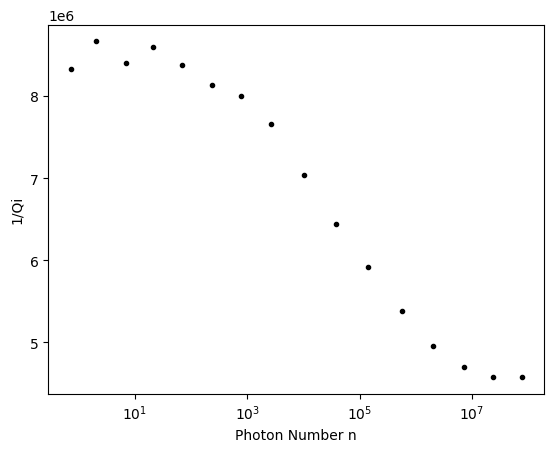

['Q_inv_t', 'Q_inv_nt', 'phi', 'nc', 'fr', 'T']
[3.76047904e+00 4.57485030e+00 4.50000000e-01 7.00000000e+03
 5.30000000e+09 1.00000000e-02]
[[Model]]
    Model(Q_inv_n)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 56
    # data points      = 16
    # variables        = 4
    chi-square         = 0.14806577
    reduced chi-square = 0.01233881
    Akaike info crit   = -66.9229991
    Bayesian info crit = -63.8326442
    R-squared          = 0.99618371
[[Variables]]
    Q_inv_t:   4.09580838 +/- 0.12988803 (3.17%) (init = 3.760479)
    Q_inv_nt:  4.36898495 +/- 0.14291207 (3.27%) (init = 4.57485)
    phi:       0.64565294 +/- 0.05965870 (9.24%) (init = 0.45)
    nc:        6980.34430 +/- 1234.12136 (17.68%) (init = 7000)
    fr:        5.3e+09 (fixed)
    T:         0.01 (fixed)
[[Correlations]] (unreported correlations are < 0.250)
    C(Q_inv_t, Q_inv_nt) = -0.9379
    C(Q_inv_t, phi)      = -0.8587
    C(Q_inv_nt, phi)     = +0.8206


Report for the Qi_

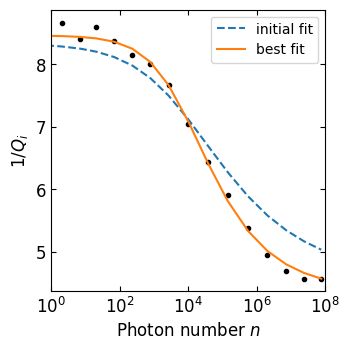

In [ ]:
fname_1 = 'Dataset-100 W_rmid_Argon'
df1 = read_csv(fname=fname_1)

#check data
check_raw = 'Y'
if check_raw == 'Y':
  plt.plot(df1[0], df1[1], 'k.', label='100 W, R2')
  plt.xscale('log')
  plt.xlabel('Photon Number n')
  plt.ylabel('1/Qi')
  plt.show()

#fit data according to scaling
b1 = 1E-6 #scale down amplitude to get the 1/Qi. Omit data if
guess1 = [0.45, 7E3, 5.3E9, 0.010]
n_arr = df1[0].values
b_arr = df1[1].values
fit_Q_tls, dict_Q_tls = lm_Q_inv_tls(xdata=n_arr, ydata=b1*b_arr, guess=guess1, show=['Y', 'Y'])

#give report on Q_inv_t (1/Q_tls) and Q_inv_nt (1/Q_non-tls)
Q_tls = get_Qi_n_std(dict_Q_tls['Q_inv_t'][0], dict_Q_tls['Q_inv_t'][1])
Q_ntls = get_Qi_n_std(dict_Q_tls['Q_inv_nt'][0], dict_Q_tls['Q_inv_nt'][1])

print('\n')
print('Report for the Qi_tls and Qi_ntls fit')
print('Q_tls = {:.3e} +/- {:.3e}'.format(Q_tls[0], Q_tls[1]))
print('Q_ntls = {:.3e} +/- {:.3e}'.format(Q_ntls[0], Q_ntls[1]))
print('phi = {:.2f} +/- {:.2f}'.format(dict_Q_tls['phi'][0], dict_Q_tls['phi'][1]))
print('n_c = {:.3e} +/- {:.3e}'.format(dict_Q_tls['nc'][0], dict_Q_tls['nc'][1]))

Note that $\phi=0.64 \pm 0.09$ as opposed to the text $\phi=0.44 \pm
 0.08$ whereas the $n_{c}$ per resonator is not stated. $f_{r}=5.3$ GHz and $T=10$ mK. The extracted $Q_{i,tls}$ is off from Fig. 1(c). which we attribute either from different datasets or due to limitation of the resolution of the online data. We used a digitized plotter to extract data from the figure.

### Essence of skinny-fat resonators measurements for better qubit fabrication
The context of a skinny-fat resonator experiment, where the gap width $w_{g}$ and center trace $w_{c}$ are varied came from an earlier work by Wang and Martinis [2] on geometric-dependent electric field and Sage [3] on radiation losses. In the work and this supplementary information, loss theory dictates that
$$\frac{1}{Q_{surface}}=\frac{1}{Q_{i,TLS}}\frac{1}{\sqrt{1+(V_{rms}/V_s^{'})^{\phi}}}$$
where $V_{rms}$ is the RMS voltage at the center trace, and $V_{s}^{'}$ is the saturation voltage. They ultimately draw an interesting relation between $V_{s}^{'}$ and the saturation electric field $E_{s}$ by the relation
$$E_{s}=\frac{\gamma V_{s}^{'}}{\alpha w_{g}}$$
where $\alpha$ and $\gamma$ are numerically determined scaling factors based from conformal mapping and inverse matrix calculation between the voltage $V$ and charge $q$ of the center trace with the CPW grounds for a resonator (see supplementary information of [2]). These scaling factors have yet to find its physical meaning, but we surmised these are material-dependent parameters considering surface fields. Note that the $V_{rms}/V_{s}^{'}$ ratio has strong analogy to the $n/n_{c}$ ratio.

For a direct analogy, the relationship between $n_{c}$ and $V_{s}^{'}$ can be established by defining the relationship between probe photons and the incident critical Photon Power $P_{c}$ on resonance through the relation [5]

$$n_{c} = \frac{P_{c}}{hf_{r}}\frac{\kappa_{ex}}{\kappa^{2}}$$. As $P_{c}=\frac{V_{S}^{'2}}{Z_{c}}$ where $Z_{c}$ is the characteristic impedance of the resonator, \kappa_{ex} is the external cavity coupling strength, $\kappa$ is the total resonator decay, the relationship between $n_{c}$ and $E_S$ is

$$n_{c}=\left(\frac{\alpha w_{g}}{\gamma} \frac{E_{S}}{Z_{c}} \right)^{2} \frac{1}{hf_{r}} \frac{\kappa_{ex}}{\kappa^2}$$. As $n \propto E_{rms}$ where $E_{rms}$ is the electric field from the center trace, it does not cancel $w_{g}$, leading to

$$\frac{1}{Q_{surface}}\propto \frac{1}{Q_{i,TLS}}\frac{1}{\sqrt{1+ \left(\frac{\gamma }{\alpha w_g } \frac{E_{rms}}{E_S} \right)^{2\phi} }} \propto \frac{1}{Q_{i,TLS}} \left( 1+(1/2) \left( \frac{\gamma}{\alpha w_{g}} \frac{E_{rms}}{E_{S}} \right) ^{2 \phi} \right) \rm{at \left(\frac{E_{rms}}{E_{S}}\right)^{2 \phi} \ll 1 }$$.

Hence, $Q_{surface}\approx w_{g}^{2}$ at low n.


# (2) Quality Factor due to Radiation Losses.

Another constraint mentioned useful for designing readout resonators and eventually qubit capacitors in X-mon or transmon structures is the radiation $Q_{rad}$ of a meandering CPW resonator characterized by Sage and company [3-4,6]

$$ \frac{1}{Q_{rad}} \propto \frac{(w_{g} + w_{s})^{m}}{A}$$

where $w_{g} + w_{s}$ are effective distances of the center trace of the resonators to the ground plane, $m$ is an exponential factor of fit ($m=2$ for straight resonators), and A is design / material dependent variables for straight resonators. This behavior is largely prominent at large $n$ [3] and must be scaled with $w_{g} + w_{s}$ to appreciate its dependences for a $\lambda/4$ resonator.


### Fitting routine for $Q_{rad}$

In [ ]:
def Q_rad(r, alpha, m, Q_nr):
  """
  Dependence of radiation with w_g and w_s based on skinny-fat resonators
  #if we do the inverse, the estimation is a lot easier than if we
  input:
    R : float
      w_g + w_s
    alpha : float
      structural parameters
    m : float
      fitting coefficient due to meandering effects (m=2 for straight lambda/4 resonators)
  """
  Qrad = alpha / (r**m)
  B = 1/Q_nr
  A = 1/Qrad + B
  return 1/A

def lm_Q_rad(xdata, ydata, guess, show=['Y', 'Y']):
  """
  Extracting Q_inv_rad and Q_inv_non-rad from skinny-fat results

  Input:
    xdata : 1D numpy array
        r in [um]
    ydata : 1D numpy array
        measured 1/Qi_ntls
    guess : list of floats
        guess[0] = w_g + w_s [mm]
        guess[1] = alpha [mm^2]
        guess[2] = Q_inv_nonrad
    show : list of floats
        show[0] = 'Y' => show fit report
        show[1] = 'Y' => show fit plot
  """

  # set model and parameters
  mod = Model(Q_rad)
  par = ['alpha', 'm', 'Q_nr'] #name of fitting functions
  p = np.asarray([guess[0], guess[1], guess[2]]) #values of the functions
  params = Parameters()
  # add with tuples: (NAME VALUE VARY MIN  MAX  EXPR  BRUTE_STEP)
  # time in nanosecond
  # guess = pars_exp['exp_decay'].value

  #we have four parameter fits
  print(par)
  print(p)

  #interest 1/Q_intls
  params.add_many((par[0], p[0], True, 0.0, np.inf),
                  (par[1], p[1], False),
                  (par[2], p[2], True, 0.0, np.inf))

  """
  Reference for fitting function
  1. Journal of Applied Physics, 109(6). doi:10.1063/1.3552890
  2. Mazin, B. A. (2004). Microwave Kinetic Inductance Detectors.
  (Ph. D. Dissertation), California Institute of Technology, California. p. 94
  """

  init = mod.eval(params, r=xdata)
  out = mod.fit(ydata, params, r=xdata, scale_covar=True)

  if show[0] == 'Y':
    print(out.fit_report(min_correl=0.25))

  if show[1] == 'Y':
    fig = plt.figure(constrained_layout=True, figsize=(cm_to_inch(8.6),
                                                       cm_to_inch(8.6)))
    spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig,
                             hspace =0.05, wspace=0.05)
    axes = fig.add_subplot(spec[0, 0])
    axes.plot(xdata, ydata, 'k.')
    axes.plot(xdata, init, '--', label='initial fit')
    axes.plot(xdata, out.best_fit, '-', label='best fit')
    axes.set_xlabel(r'$w_{s}+w_{g}$', fontsize=12)
    axes.set_ylabel(r'$Q_{i}$',fontsize=12)
    axes.tick_params(direction='in', right=True, top=True, labelsize=12)
    axes.legend()

  """Method - iterable dictionaries {} more efficient. Names are keys and the dictionary
  contains a list. [0] refers to best fit whereas [1] would be the standard error"""
  out_dict_val_stderr = {par[i]: [out.params[par[i]].value, out.params[par[i]].stderr]
  for i in range(len(par))}

  return out.best_fit, out_dict_val_stderr

Perform Fitting Data Analysis based on Fig 4 of Ref. [3]

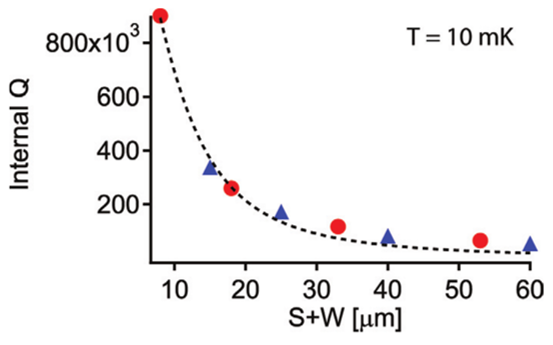

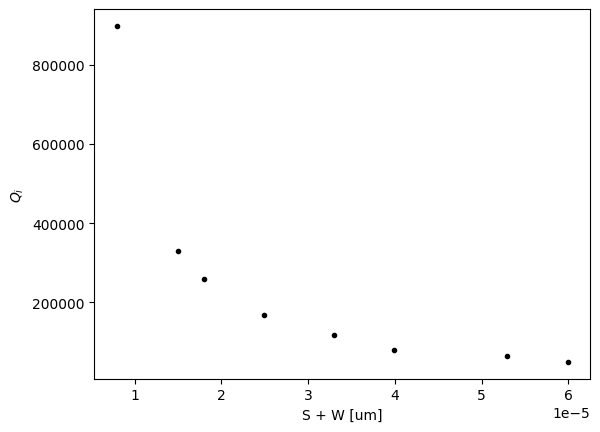

['alpha', 'm', 'Q_nr']
[2.8e+08 2.3e+00 1.5e+06]
[[Model]]
    Model(Q_rad)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 8
    # variables        = 2
    chi-square         = 7.4778e+09
    reduced chi-square = 1.2463e+09
    Akaike info crit   = 169.246103
    Bayesian info crit = 169.404986
    R-squared          = 0.98652723
[[Variables]]
    alpha:  2.4503e+08 +/- 27390010.1 (11.18%) (init = 2.8e+08)
    m:      2.3 (fixed)
    Q_nr:   1564659.45 +/- 184334.301 (11.78%) (init = 1500000)
[[Correlations]] (unreported correlations are < 0.250)
    C(alpha, Q_nr) = -0.8161


Report for the Qi_rad and Qi_nrad fit


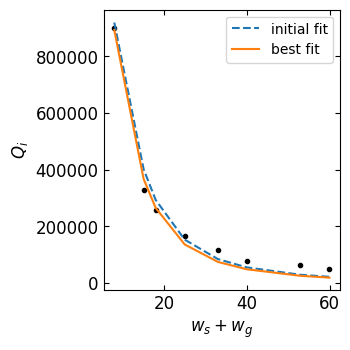

In [ ]:
fname_2 = 'r_vs_Qirad'
df2 = read_csv(fname=fname_2)

#check data
check_raw = 'Y'
if check_raw == 'Y':
  plt.plot(df2[0], df2[1], 'k.')
  plt.xlabel('S + W [um]')
  plt.ylabel(r'$Q_i$')
  plt.show()

#fit data according to scaling
a2 = 1E6 #conversion from m to um
guess2 = [2.8E8, 2.3, 1.5E6] #from Ref. 3
r_arr = df2[0].values
Qrad_arr = df2[1].values

#solution works but the issue is for Qi to blow up at higher orders.
fit_Q_rad, dict_Q_rad = lm_Q_rad(xdata=a2*r_arr, ydata=Qrad_arr, guess=guess2, show=['Y', 'Y'])

#give report on Q_inv_t (1/Q_tls) and Q_inv_nt (1/Q_non-tls)

print('\n')
print('Report for the Qi_rad and Qi_nrad fit')

The fit works but the Q_nr is way off from the published results if $m=1.5-2.5$. Fixing $m=2.3$ gives low errors which has good fidelity with the published results for $\alpha$ and $Q_{n,rad}$. One can do the inverse calculation as below but the errors become problematic. Hence, one must be very careful with fitting models.

### Radiative Model for a $\lambda/4$ resonators

A complete definition of a straight radiative loss of a $\lambda/4$ resonator is defined in Ben Mazin's thesis [6] though the conformal mapping derivation, which came from "Vayokanis and J. Zmuidzinas, Radiative losses from 2-D appertures, 2011", is not made accessible. The radiative loss is described as:

$$Q_{rad}= \frac{\pi (1+ϵ)^{2}}{2ϵ^{5/2}} \frac{η_0}{Z_{0}} \frac{1}{I^{'}(ϵ,n)} \frac{1}{n-1/2} \left( \frac{l}{b} \right)^{2}$$

where $ϵ$ is the dielectric constant of the susbtrate ($ϵ_{Si}=10$), $\eta=377 \Omega$ is the vacuum impedance, $Z_{0}$ is the characteristic impedance of the CPW, $n$ is the mode number and $I^{'}(ϵ,n)$ is a function whose values are tabulated in [6], $l$ is the total length of the $\lambda/4$ resonator, and $b=2w_s + w_c$ is the total width of the CPW center trace, and the gap to ground. In a high resistivity Si substrate, $I^{'}(ϵ=10,n=1)=1.62$.

$Z_{0}$ takes from the case of a conventional coplanar waveguide on an infinitely thick dielectric substrate [7]:
$$ Z_{0}= \frac{30 \pi}{\sqrt{(1+ϵ)/2}}\frac{K(k_{0}^{'})}{K(k_{0})}$$
where

$$k_{0} = \frac{w_c}{w_c + 2w_s}$$
and
$$k_{0}^{'} = \sqrt{1-k_0^2}$$

We see from the model, that if $I^{'}(ϵ,n)$ is not a CPW material dependent term, that the radiative loss is not related to the CPW material properties, but rather is a property of the CPW strucutre.

Disclaimer: I retracted the $Q_{rad}$ of a spiral resonator due to 1) irrelevance to CPW analysis and 2) proprietory concerns. One can see the full model from the Measurement Tuneup (202311).pptx.

In [ ]:
def Z0(wc, ws, eps):
  """
  Characteristic Impedance of the Resonator
  """
  k0 = wc/(wc+2*ws)
  k0p = np.sqrt(1-k0**2)

  A = 30*np.pi/np.sqrt((1+eps)/2)
  B = sp.special.ellipk(k0p)
  C = sp.special.ellipk(k0)

  exp = A*B/C
  return exp

def Q_rad_straight(wc, ws, eps, l, n=1, m=2):
  """
  Quality factor of straight resonators due to Radiation
  input:
    wc : float
    center trace width in m
    ws : float
    gap spacing in m
    eps : float
    dielectric constant
    l : float
    resonator length
    n : float
    mode number
    m : float
    exponential term (for straight, m=2)
  """
  eta0 = 377 #ohm
  b = wc + 2*ws

  #expression
  A = np.pi(1+eps)**2/(2*eps**(5/2))
  B = 377 / Z0(wc, ws, eps)
  C = 1/1.62
  D = 1/(n-0.5)
  E = l**m

  #total expression
  const = A*B*C*D*E
  print(const)
  exp = const / b
  return exp

In [ ]:
#test scaling script

These constraints all are needed to discount geometric designs from material effects, which would be useful in making a near lossless qubit capacitor, which translates to higher $T_{1}$ by design. By performing skinny-fat resonator analysis and scaling $w_{g}$ and $w_{s}$ from $Q_{i}$, one can extract the coefficients that best describe material, design and packaging processes for a qubit and resonator package.


# (3) Dissipation due to eddy currents in the package

Recent works by Huang and Wellstood [6] have demonstrated dissection between participation ratios in CPW that limit the resonator Q using finite element method that is of interest in making good qubit resonator and resonator packaging which is due to eddy currents within the package. They proved the influence of lossy glue and packaging obfuscate radiation from the CPW ground, which can explain deviations in specific packages. Nevertheless, we hope this analysis helps in understanding relaxation mechanism towards better performing QPUs.

Quasiparticle effects based on Thermal Quasiparticles (Paik, H., Schuster, D. I., Bishop, L. S., Kirchmair, G., Catelani, G., Sears, A. P., . . . Schoelkopf, R. J. (2011). Observation of high coherence in Josephson junction qubits measured in a three-dimensional circuit QED architecture. Phys Rev Lett, 107(24), 240501. doi:10.1103/PhysRevLett.107.240501)

# References

1. Van Damme, J., Ivanov, T., Favia, P., Conard, T., Verjauw, J., Acharya, R., . . . De Greve, K. (2023). Argon-Milling-Induced Decoherence Mechanisms in Superconducting Quantum Circuits. Physical Review Applied, 20(1). doi:10.1103/PhysRevApplied.20.014034
2. Wang, H., Hofheinz, M., Wenner, J., Ansmann, M., Bialczak, R. C., Lenander, M., . . . Martinis, J. M. (2009). Improving the coherence time of superconducting coplanar resonators. Applied Physics Letters, 95(23). doi:10.1063/1.3273372
3. Sage, J. M., Bolkhovsky, V., Oliver, W. D., Turek, B., & Welander, P. B. (2011). Study of loss in superconducting coplanar waveguide resonators. Journal of Applied Physics, 109(6). doi:10.1063/1.3552890
4. A. Vayokanis and J. Zmuidzinas, Radiative losses from 2-D appertures, 2011
5. Teufel, J. D., Donner, T., Li, D., Harlow, J. W., Allman, M. S., Cicak, K., . . . Simmonds, R. W. (2011). Sideband cooling of micromechanical motion to the quantum ground state. Nature, 475(7356), 359-363. doi:10.1038/nature10261
6. Mazin, B. A. (2004). Microwave Kinetic Inductance Detectors. (Ph. D. Dissertation), California Institute of Technology, California. p. 44
7. Simons, R. N. (2001). Coplanar Waveguide Circuits, Components, and Systems: John Wiley & Sons, Inc.
8. Huang, Y., Huang, Y.-H., Wang, H., Steffen, Z., Cripe, J., Wellstood, F. C., & Palmer, B. S. (2023). Identification and mitigation of conducting package losses for quantum superconducting devices. Applied Physics Letters, 123(4). doi:10.1063/5.0155053

#Appendix

### Perform fitting for Q_{rad} using $1/Q_{i}$ approach

In [ ]:
def Q_inv_rad(r, alpha, m, Q_nr):
  """
  Dependence of radiation with w_g and w_s based on skinny-fat resonators
  #if we do the inverse, the estimation is a lot easier than if we
  input:
    R : float
      w_g + w_s
    alpha : float
      structural parameters
    m : float
      fitting coefficient due to meandering effects (m=2 for straight lambda/4 resonators)
  """
  Qrad = alpha / (r**m)
  B = 1.0/Q_nr
  A = 1.0/Qrad + B
  return A

def lm_Q_inv_rad(xdata, ydata, guess, show=['Y', 'Y']):
  """
  Extracting Q_inv_rad and Q_inv_non-rad from skinny-fat results

  Input:
    xdata : 1D numpy array
        r in [um]
    ydata : 1D numpy array
        measured 1/Qi_ntls
    guess : list of floats
        guess[0] = w_g + w_s [mm]
        guess[1] = alpha [mm^2]
        guess[2] = Q_inv_nonrad
    show : list of floats
        show[0] = 'Y' => show fit report
        show[1] = 'Y' => show fit plot
  """

  # set model and parameters
  mod = Model(Q_inv_rad)
  par = ['alpha', 'm', 'Q_nr'] #name of fitting functions
  p = np.asarray([guess[0], guess[1], guess[2]]) #values of the functions
  params = Parameters()
  # add with tuples: (NAME VALUE VARY MIN  MAX  EXPR  BRUTE_STEP)
  # time in nanosecond
  # guess = pars_exp['exp_decay'].value

  #we have four parameter fits
  print(par)
  print(p)

  #interest 1/Q_intls
  params.add_many((par[0], p[0], True, 0.0, np.inf),
                  (par[1], p[1], True, 1.5, 2.5),
                  (par[2], p[2], True, 0.0, np.inf))

  """
  Reference for fitting function
  1. Journal of Applied Physics, 109(6). doi:10.1063/1.3552890
  2. Mazin, B. A. (2004). Microwave Kinetic Inductance Detectors.
  (Ph. D. Dissertation), California Institute of Technology, California. p. 94
  """

  init = mod.eval(params, r=xdata)
  out = mod.fit(ydata, params, r=xdata, scale_covar=True)

  if show[0] == 'Y':
    print(out.fit_report(min_correl=0.25))

  if show[1] == 'Y':
    fig = plt.figure(constrained_layout=True, figsize=(cm_to_inch(8.6),
                                                       cm_to_inch(8.6)))
    spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig,
                             hspace =0.05, wspace=0.05)
    axes = fig.add_subplot(spec[0, 0])
    axes.plot(xdata, ydata, 'k.')
    axes.plot(xdata, init, '--', label='initial fit')
    axes.plot(xdata, out.best_fit, '-', label='best fit')
    axes.set_xlabel(r'$w_{s}+w_{g}$', fontsize=12)
    axes.set_ylabel(r'$1/Q_{i}$',fontsize=12)
    axes.tick_params(direction='in', right=True, top=True, labelsize=12)
    axes.legend()

  """Method - iterable dictionaries {} more efficient. Names are keys and the dictionary
  contains a list. [0] refers to best fit whereas [1] would be the standard error"""
  out_dict_val_stderr = {par[i]: [out.params[par[i]].value, out.params[par[i]].stderr]
  for i in range(len(par))}

  return out.best_fit, out_dict_val_stderr

Perform Fitting Data Analysis for Q_rad based on Fig 4 of Ref. [3] but using the 1/Qi method

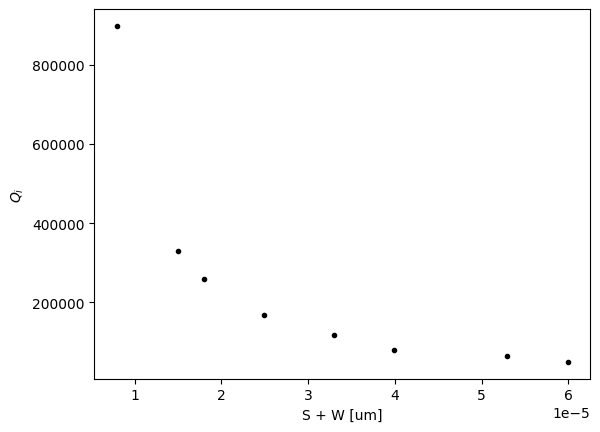

['alpha', 'm', 'Q_nr']
[2.8e+08 2.3e+00 1.5e+06]
[[Model]]
    Model(Q_inv_rad)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 100
    # data points      = 8
    # variables        = 3
    chi-square         = 4.4676e-12
    reduced chi-square = 8.9353e-13
    Akaike info crit   = -219.708839
    Bayesian info crit = -219.470514
    R-squared          = 0.98575909
[[Variables]]
    alpha:  24074382.7 +/- 26406188.4 (109.69%) (init = 2.8e+08)
    m:      1.50000000 +/- 0.00536197 (0.36%) (init = 2.3)
    Q_nr:   1440659.13 +/- 2512250.62 (174.38%) (init = 1500000)
[[Correlations]] (unreported correlations are < 0.250)
    C(alpha, m)    = +0.9988
    C(alpha, Q_nr) = -0.9068
    C(m, Q_nr)     = -0.8901


Report for the Qi_rad and Qi_nrad fit


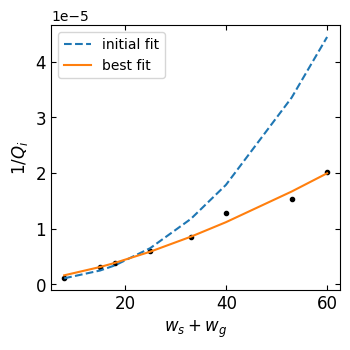

In [ ]:
fname_2 = 'r_vs_Qirad'
df2 = read_csv(fname=fname_2)

#check data
check_raw = 'Y'
if check_raw == 'Y':
  plt.plot(df2[0], df2[1], 'k.')
  plt.xlabel('S + W [um]')
  plt.ylabel(r'$Q_i$')
  plt.show()

#fit data according to scaling
a2 = 1E6 #conversion from m to um
guess2 = [2.8E8, 2.3, 1.5E6] #from Ref. 3
r_arr = df2[0].values
Qrad_arr = df2[1].values
Q_inv_rad_arr = np.array([1.0/Qrad_arr[i] for i in range(len(Qrad_arr))])

#solution works but the issue is for Qi to blow up at higher orders.
fit_Q_inv_rad, dict_Q_inv_rad = lm_Q_inv_rad(xdata=a2*r_arr, ydata=Q_inv_rad_arr, guess=guess2, show=['Y', 'Y'])

#give report on Q_inv_t (1/Q_tls) and Q_inv_nt (1/Q_non-tls)

print('\n')
print('Report for the Qi_rad and Qi_nrad fit')

The fit looks better on both cases if $mϵ(1.5, 2.5)$. The data must have been fitted by eye by the time the paper is written, or different fitting algorithm is used. Nevertheless, the $\alpha$ and $n_{r}$ extracted is close to the published results. If we constrain $m=2.3$ the fit for alpha and $Q_{nr}$ becomes way off.